In [1]:
import biovec
import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [2]:
n_grams = 3

# Load saved model
pv = biovec.models.load_protvec('./models/ngram-' + str(n_grams) + '.model')

In [3]:
# Prepare dataset for prediction
protein_names, sequences, labels = [], [], []


'''
    Labels:
        "+" stands for "binding protein" => 1
        "-" stands for "non-binding" => 0
'''
def convert_label(label_string):
 
    if label_string == "+":
        return 1
    elif label_string == "-":
        return 0
    else:
        return None

    
# Open file containing dataset    
with open('./ppi_data.fasta') as f:
    lines = f.read().splitlines()
    
    for i in range(len(lines)):
        
        if i % 3 == 0:
            protein_names.append(lines[i])
        elif i % 3 == 1:
            sequences.append(lines[i])
        elif i % 3 == 2:
            labels.append([convert_label(letter) for letter in lines[i]])
            
protein_names = np.array(protein_names)
sequences = np.array(sequences)
labels = np.array(labels)

assert(protein_names.shape[0] == sequences.shape[0] == labels.shape[0])

print(protein_names[0])
print(sequences[0])
print(labels[0])

>P0A8Q6
MGKTNDWLDFDQLAEEKVRDALKPPSMYKVILVNDDYTPMEFVIDVLQKFFSYDVERATQLMLAVHYQGKAICGVFTAEVAETKVAMVNKYARENEHPLLCTLEKA
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


In [4]:
window_size = 7
vector_size = 100

X, y = [], []

# Iterates over all proteins in dataset
for i in range(len(sequences)):

    # Loop over sequence
    for j in range(0,len(sequences[i]) - window_size + 1):
        sub_sequence = sequences[i][j:j+window_size]

        # Sum vectors of n grams
        tmp = np.zeros(vector_size)
        for k in range(0, window_size - n_grams + 1):
            
            # There are few words that are not contained in the dictionary
            if sub_sequence[k:k+n_grams] in pv:
                tmp = tmp + np.array(pv[sub_sequence[k:k+n_grams]])
            else:
                print(sub_sequence[k:k+n_grams])
    
        X.append(tmp)
        y.append(labels[i][j+3]) 
        
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

/home/francesco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/francesco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


(89541, 100)
(89541,)


In [5]:
def resample(sample_idx, data_y, oversample=True):
    pos_idx = np.array([idx for idx in sample_idx if data_y[idx] == 1])
    neg_idx = np.array([idx for idx in sample_idx if data_y[idx] == 0])

    num_pos = pos_idx.size
    num_neg = neg_idx.size

    rnd = np.random.RandomState(42)

    if num_pos < num_neg:
        if oversample:
            n = num_neg // num_pos
            d = num_neg % num_pos

            new_idx = rnd.choice(pos_idx, size=d, replace=False)
            new_idx = np.concatenate((new_idx, np.repeat(pos_idx, n), neg_idx))
        else:
            new_idx = rnd.choice(neg_idx, size=num_pos, replace=False)
            new_idx = np.concatenate((new_idx, pos_idx))
    elif num_pos > num_neg:
        if oversample:
            n = num_pos // num_neg
            d = num_pos % num_neg

            new_idx = rnd.choice(neg_idx, size=d, replace=False)
            new_idx = np.concatenate((new_idx, np.repeat(neg_idx, n), pos_idx))
        else:
            new_idx = rnd.choice(pos_idx, size=num_neg, replace=False)
            new_idx = np.concatenate((new_idx, neg_idx))
    else:
        return sample_idx

    rnd.shuffle(new_idx)

    return new_idx

In [6]:
# Standardize vectors
rs1 = RobustScaler()
rs2 = RobustScaler()

# Principal component analysis
pca = PCA(n_components=10,
          svd_solver='full',
          whiten=False,
          random_state=42)
# NN
clf = MLPClassifier(solver='adam',
                    hidden_layer_sizes=(50, ),
                    alpha=0.1,
                    epsilon=0.0001,
                    learning_rate_init=0.001,
                    max_iter=200,
                    early_stopping=True,
                    validation_fraction=0.2,
                    random_state=42)

kfold = StratifiedKFold(n_splits=10, random_state=42)

cv_accuracy, cv_precision, cv_recall, cv_auc = [], [], [], []

for i, (train, test) in enumerate(kfold.split(X, y)):
    print('CV-Split {}'.format(i + 1))

    train = resample(train, y, oversample=False)

    model = Pipeline(steps=[('rs1', rs1), ('pca', pca), ('rs2', rs2), ('clf', clf)])

    model.fit(X[train], y[train])

    # Predict on test data
    predictions = model.predict(X[test])
    
    # Scores
    cv_accuracy.append(accuracy_score(y[test], predictions))
    cv_precision.append(precision_score(y[test], predictions))
    cv_recall.append(recall_score(y[test], predictions, average='micro'))
    cv_auc.append(roc_auc_score(y[test], predictions))
    
print(np.mean(np.array(cv_accuracy)))
print(np.mean(np.array(cv_precision)))
print(np.mean(np.array(cv_recall)))
print(np.mean(np.array(cv_auc)))

CV-Split 1
CV-Split 2
CV-Split 3
CV-Split 4
CV-Split 5
CV-Split 6
CV-Split 7
CV-Split 8
CV-Split 9
CV-Split 10
0.5241158376851557
0.31392098073317254
0.5241158376851557
0.5447881498040423


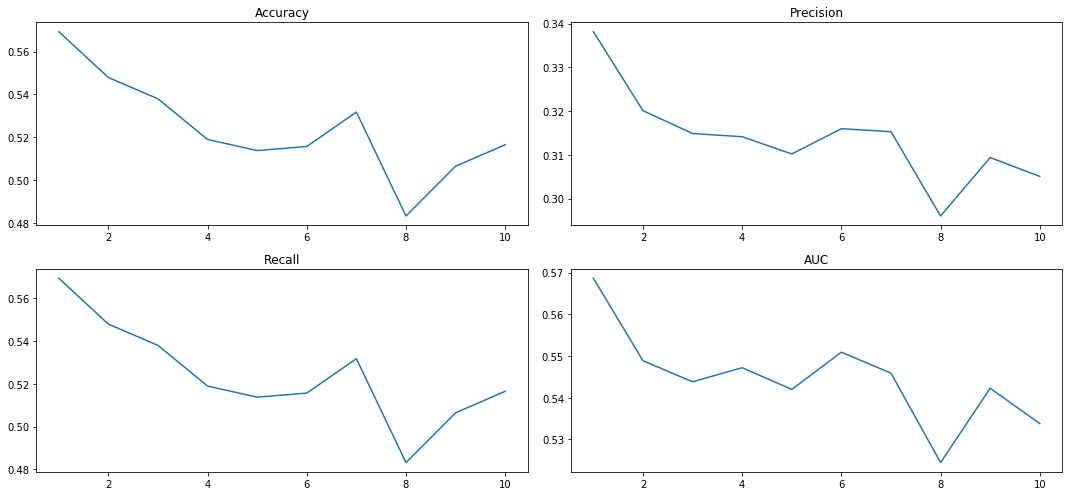

In [7]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,7))

ax1.plot(list(range(1,11)), cv_accuracy)
ax1.set_title('Accuracy')
ax2.plot(list(range(1,11)), cv_precision)
ax2.set_title('Precision')
ax3.plot(list(range(1,11)), cv_recall)
ax3.set_title('Recall')
ax4.plot(list(range(1,11)), cv_auc)
ax4.set_title('AUC')
plt.tight_layout()

plt.savefig('./plots/' + str(n_grams) + '-grams.png')